In [1]:
!gdown '1-Ex3ssVpwPibjGzB9QTeMCcsRvZ9yceK'

Downloading...
From: https://drive.google.com/uc?id=1-Ex3ssVpwPibjGzB9QTeMCcsRvZ9yceK
To: /content/dataset.zip
100% 32.5M/32.5M [00:00<00:00, 247MB/s]


### 设置超参数

In [2]:
IMG_SIZE = 625
BATCH_SIZE = 2
EPOCHS = 1000
NUM_KEYPOINTS = 4 * 2  # 4 pairs each having x and y coordinates

### 准备数据集

In [3]:
!unzip -oq dataset.zip
!rm -rf ./dataset/.git
!rm -rf ./dataset/.DS_Store
!rm -rf __MACOSX
!rm -rf ./resized
!mkdir ./resized

### 加载数据集，将数据集转换成如下格式的字典。

```json
{
  "image_path1" => [[
    627.6153846153846,
    872.6410256410256
  ], ...],
  "image_path2" => [...]
}
```

In [4]:
import os
import json
import pathlib
from PIL import Image
from matplotlib import pyplot as plt

json_dict = {}
for p in pathlib.Path('./dataset').glob('*'):
  plate = p.name  
  path = str(p)
  with open(f"{path}/{plate}.json") as file:
    os.mkdir(f"./resized/{plate}")

    normal_image_path = f"{path}/{plate}.jpg"
    resized_image_path = f"./resized/{plate}/{plate}.jpg"

    image = Image.open(normal_image_path)
    resized_image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    resized_image.save(resized_image_path)

    points = json.load(file)['shapes'][0]['points']
    for p in points:
      p[0] = p[0] / image.width * IMG_SIZE
      p[1] = p[1] / image.height * IMG_SIZE

    json_dict[resized_image_path] = points

### 根据 `key` 获取对应 `points`

In [5]:
# Utility for reading an image and for getting its annotations.
def get_dog(key):  
  return { 'joints': json_dict[key], 'img_data': plt.imread(key) }

### 定义显示关键点方法

In [6]:
import numpy as np
from imgaug.augmentables.kps import KeypointsOnImage

def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=1, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for ax_all, image, current_keypoint in zip(axes, images, keypoints):
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c='red', marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c='red', marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()

### 检查一下数据

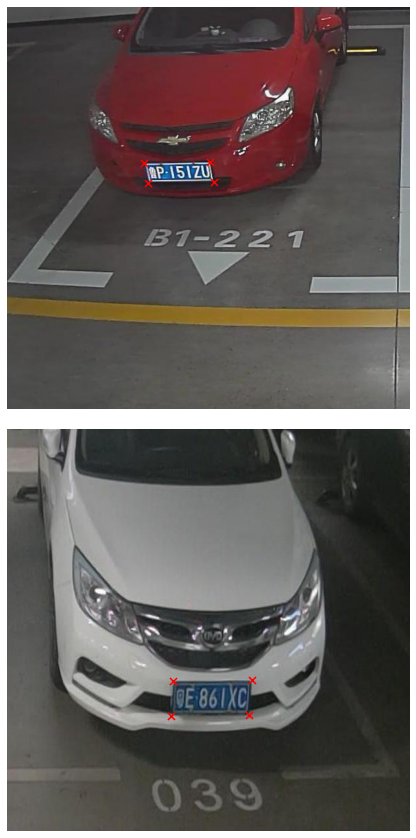

In [7]:
# 选取两个样本检查
samples = list(json_dict.keys())
num_samples = 2
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_dog(sample)
    images.append(data["img_data"])
    keypoints.append(data["joints"])

visualize_keypoints(images, keypoints)

### 构建数据生成器

In [8]:
from tensorflow import keras

class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_dog(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            current_image = data["img_data"]
            batch_images[i,] = current_image

            kp_temp = []
            for keypoint in current_keypoint:
                kp_temp.append(np.nan_to_num(keypoint[0]))
                kp_temp.append(np.nan_to_num(keypoint[1]))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp) 

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

In [9]:
import imgaug.augmenters as iaa

train_aug = iaa.Sequential([])
test_aug = iaa.Sequential([])

### 准备训练集和验证集

In [10]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.1) :],
    samples[: int(len(samples) * 0.1)],
)

### 检查训练集和验证集

Total batches in training set: 161
Total batches in validation set: 17


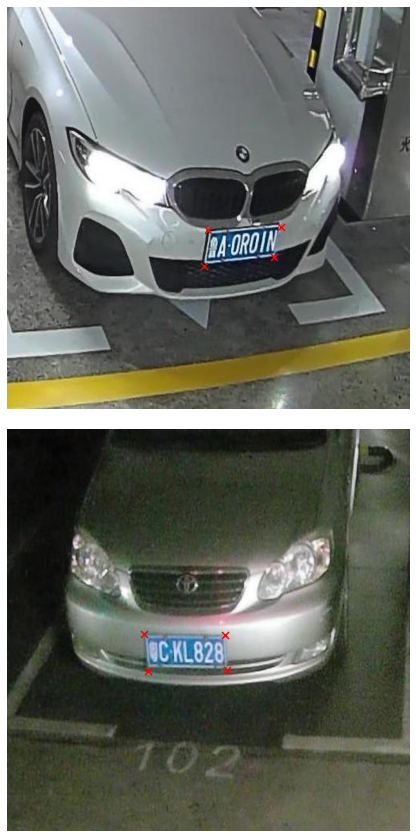

In [11]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))

sample_keypoints = sample_keypoints[:4].reshape(-1, 4, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

### 构建模型

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

def build_model(image_size):
    inputs = layers.Input(shape=(image_size[0], image_size[1], 3))
    # Conv => Activation => Pool blocks.
    x = layers.Conv2D(33, kernel_size=(5, 5), activation='relu')(inputs)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(99, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(99, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x) 
    x = layers.Conv2D(99, kernel_size=(3, 3), activation='relu')(x)
    x = layers.Conv2D(99, kernel_size=(3, 3), activation='relu')(x)   
    x = layers.MaxPool2D((2, 2))(x)                 
    # Linear layers.
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=256, activation='relu')(x)
    x = layers.Dense(units=8)(x)
    model = tf.keras.Model(inputs, outputs=x)
    return model

### 生成模型

In [37]:
model = build_model((625, 625))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 625, 625, 3)]     0         
                                                                 
 conv2d_49 (Conv2D)          (None, 621, 621, 33)      2508      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 310, 310, 33)     0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 308, 308, 33)      9834      
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 154, 154, 33)     0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 152, 152, 66)      1966

### 预览模型架构

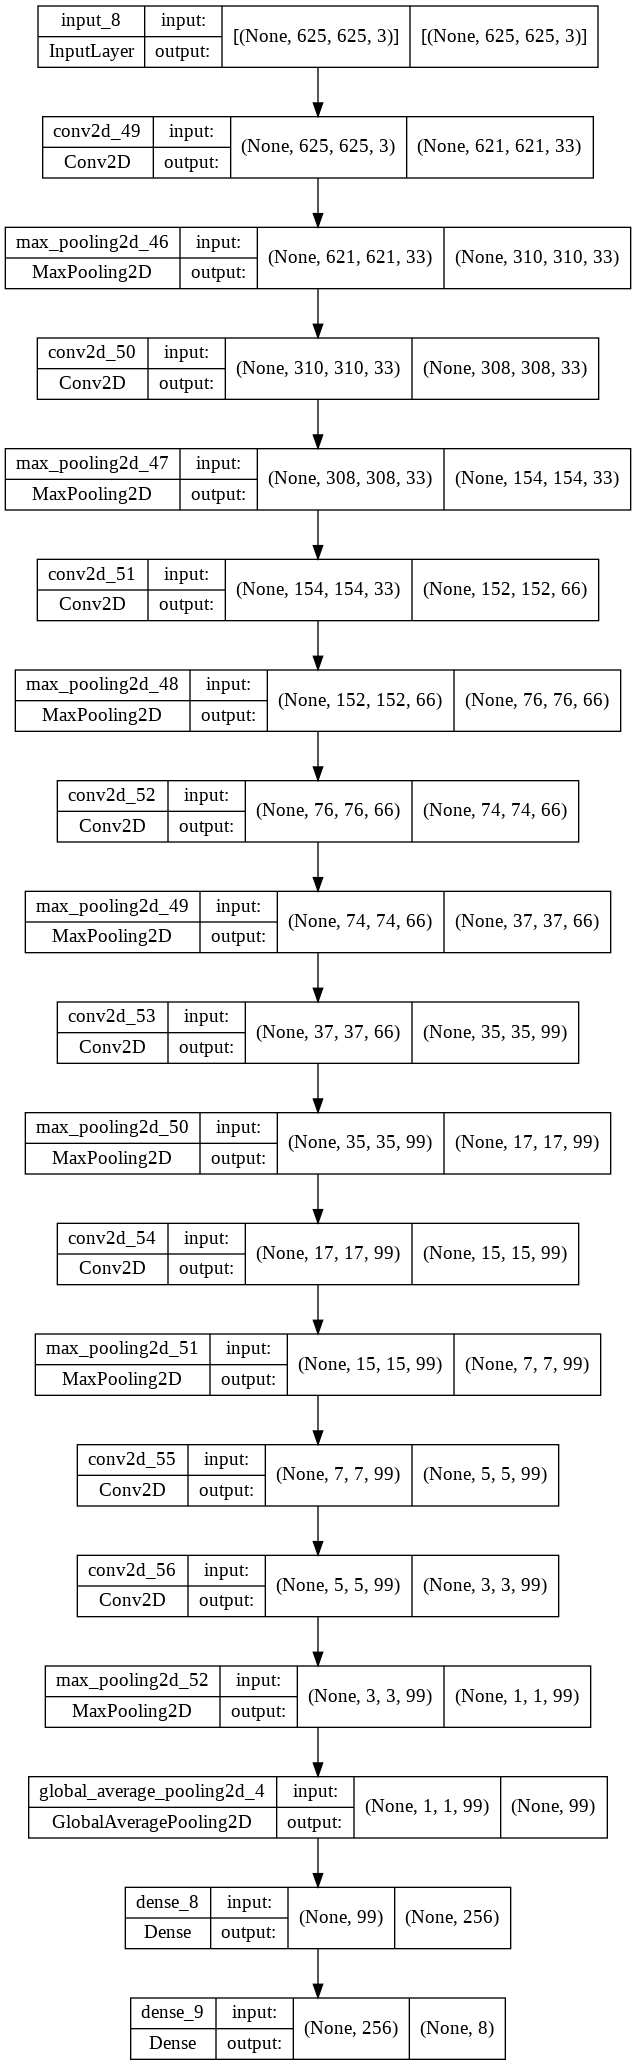

In [38]:
tf.keras.utils.plot_model(model, show_shapes=True)

### 训练

In [ ]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/1000
161/161 [==============================] - 6s 35ms/step - loss: 4.7007e-05 - val_loss: 0.0021
Epoch 2/1000
161/161 [==============================] - 6s 34ms/step - loss: 5.5956e-05 - val_loss: 0.0020
Epoch 3/1000
161/161 [==============================] - 6s 34ms/step - loss: 5.9999e-05 - val_loss: 0.0019
Epoch 4/1000
161/161 [==============================] - 6s 34ms/step - loss: 7.5054e-05 - val_loss: 0.0019
Epoch 5/1000
161/161 [==============================] - 6s 34ms/step - loss: 7.5137e-05 - val_loss: 0.0017
Epoch 6/1000
161/161 [==============================] - 6s 34ms/step - loss: 8.7357e-05 - val_loss: 0.0021
Epoch 7/1000
161/161 [==============================] - 6s 34ms/step - loss: 1.2237e-04 - val_loss: 0.0016
Epoch 8/1000
161/161 [==============================] - 6s 35ms/step - loss: 1.3742e-04 - val_loss: 0.0018
Epoch 9/1000
161/161 [==============================] - 6s 34ms/step - loss: 1.2330e-04 - val_loss: 0.0019
Epoch 10/1000
161/161 [==============

### 显示训练结果

实际


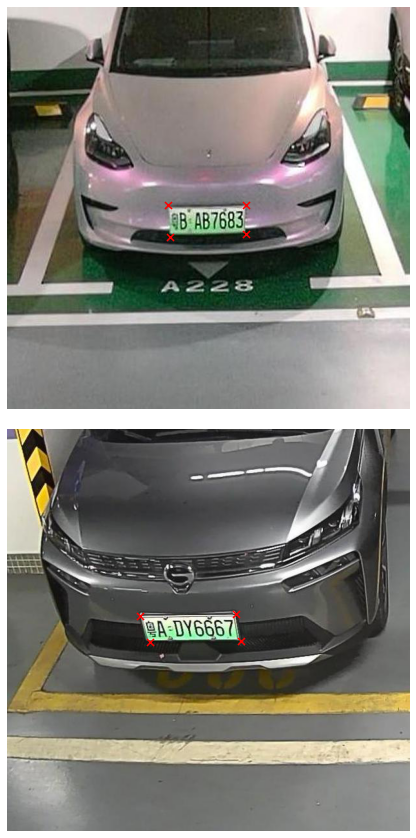

模型预测


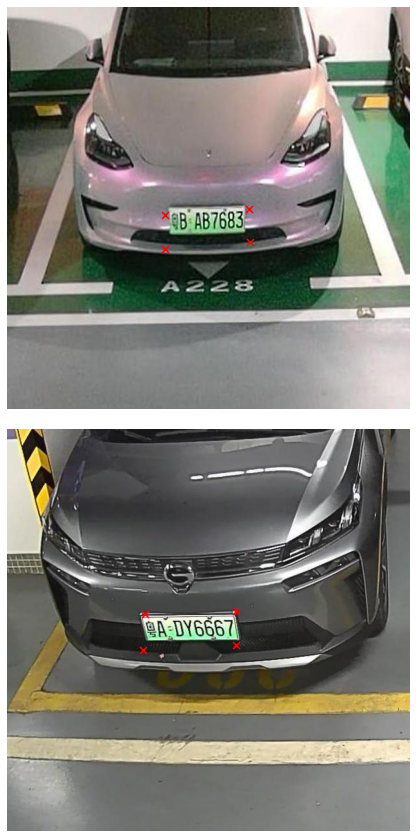

In [40]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:2]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 4, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 4, 2) * IMG_SIZE
 
print("实际")
visualize_keypoints(sample_val_images, sample_val_keypoints)

print("模型预测")
visualize_keypoints(sample_val_images, predictions)